Parameter Heatmap
==========

This tutorial will show how to optimize strategies with multiple parameters and how to examine and reason about optimization results.
It is assumed you're already familiar with
[basic _backtesting.py_ usage](https://kernc.github.io/backtesting.py/doc/examples/Quick%20Start%20User%20Guide.html).

First, let's again import our helper moving average function.
In practice, one should use functions from an indicator library, such as
[TA-Lib](https://github.com/mrjbq7/ta-lib) or
[Tulipy](https://tulipindicators.org).

In [1]:
from backtesting.test import SMA

/home/jk/PycharmProjects/backtesting/venv/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

Our strategy will be a similar moving average cross-over strategy to the one in
[Quick Start User Guide](https://kernc.github.io/backtesting.py/doc/examples/Quick%20Start%20User%20Guide.html),
but we will use four moving averages in total:
two moving averages whose relationship determines a general trend
(we only trade long when the shorter MA is above the longer one, and vice versa),
and two moving averages whose cross-over with daily _close_ prices determine the signal to enter or exit the position.

In [2]:
from backtesting import Strategy
from backtesting.lib import crossover


class Sma4Cross(Strategy):
    n1 = 50
    n2 = 100
    n_enter = 20
    n_exit = 10
    
    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        self.sma_enter = self.I(SMA, self.data.Close, self.n_enter)
        self.sma_exit = self.I(SMA, self.data.Close, self.n_exit)
        
    def next(self):
        
        if not self.position:
            
            # On upwards trend, if price closes above
            # "entry" MA, go long
            
            # Here, even though the operands are arrays, this
            # works by implicitly comparing the two last values
            if self.sma1 > self.sma2:
                if crossover(self.data.Close, self.sma_enter):
                    self.buy()
                    
            # On downwards trend, if price closes below
            # "entry" MA, go short
            
            else:
                if crossover(self.sma_enter, self.data.Close):
                    self.sell()
        
        # But if we already hold a position and the price
        # closes back below (above) "exit" MA, close the position
        
        else:
            if (self.position.is_long and
                crossover(self.sma_exit, self.data.Close)
                or
                self.position.is_short and
                crossover(self.data.Close, self.sma_exit)):
                
                self.position.close()

It's not a robust strategy, but we can optimize it.

[Grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search)
is an exhaustive search through a set of specified sets of values of hyperparameters. One evaluates the performance for each set of parameters and finally selects the combination that performs best.

Let's optimize our strategy on Google stock data using _randomized_ grid search over the parameter space, evaluating at most (approximately) 200 randomly chosen combinations:

In [3]:
%%time 

from backtesting import Backtest
from backtesting.test import GOOG


backtest = Backtest(GOOG, Sma4Cross, commission=.002)

stats, heatmap = backtest.optimize(
    n1=range(10, 110, 10),
    n2=range(20, 210, 20),
    n_enter=range(15, 35, 5),
    n_exit=range(10, 25, 5),
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    max_tries=200,
    random_state=0,
    return_heatmap=True)

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 207 ms, sys: 56.6 ms, total: 264 ms
Wall time: 3.53 s


Notice `return_heatmap=True` parameter passed to
[`Backtest.optimize()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.optimize).
It makes the function return a heatmap series along with the usual stats of the best run.
`heatmap` is a pandas Series indexed with a MultiIndex, a cartesian product of all permissible (tried) parameter values.
The series values are from the `maximize=` argument we provided.

In [4]:
heatmap

n1   n2   n_enter  n_exit
20   60   15       10       10102.867
     80   15       10        9864.219
     100  15       10       11003.218
30   40   20       15       11771.286
          25       15       16178.548
     60   15       10       11297.192
          25       10       12316.818
                   20       11474.947
     80   15       10        8595.678
          25       15       14920.305
                               ...   
100  160  30       20        9369.124
     180  20       15       14260.408
          25       10        8592.888
                   20        8887.093
          30       10        8912.898
     200  15       10       13118.248
          20       10       11308.462
                   15       16350.944
          25       10        8991.553
          30       10        9953.070
Name: Equity Final [$], Length: 177, dtype: float64

This heatmap contains the results of all the runs,
making it very easy to obtain parameter combinations for e.g. three best runs:

In [5]:
heatmap.sort_values().iloc[-3:]

n1   n2   n_enter  n_exit
100  120  15       10       18159.064
     160  20       15       19216.545
50   160  20       15       19565.692
Name: Equity Final [$], dtype: float64

But we use vision to make judgements on larger data sets much faster.
Let's plot the whole heatmap by projecting it on two chosen dimensions.
Say we're mostly interested in how parameters `n1` and `n2`, on average, affect the outcome.

In [6]:
hm = heatmap.groupby(['n1', 'n2']).mean().unstack()
hm = hm[::-1]
hm

n2,40,60,80,100,120,140,160,180,200
n1,,,,,,,,,
100,NaN,NaN,NaN,NaN,11253.157,7101.260,11323.427,10163.322,11944.455
90,NaN,NaN,NaN,8958.143,9538.050,9884.416,9685.920,11343.644,8806.572
80,NaN,NaN,NaN,10863.109,7721.244,9139.946,8813.950,10414.656,8908.486
70,NaN,NaN,14712.143,7192.893,10403.015,10065.280,8293.734,9895.782,9360.478
60,NaN,NaN,9232.415,8046.486,10838.454,12876.589,10312.955,9427.545,9555.402
50,NaN,8383.465,10180.503,10563.790,9081.947,14272.266,13575.861,11383.465,10053.469
40,NaN,13666.448,NaN,7549.100,10629.479,12860.994,11405.291,10863.807,10658.140
30,13974.917,11696.319,11757.991,15092.994,13152.243,11518.687,11271.354,11384.551,10649.053
20,NaN,10102.867,9864.219,11003.218,NaN,NaN,NaN,NaN,NaN


Let's plot this table as a heatmap:

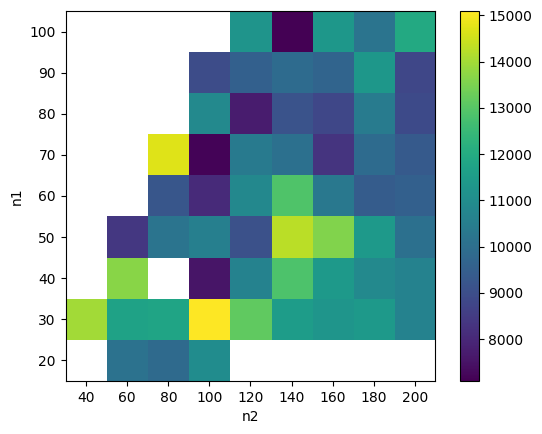

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(hm, cmap='viridis')
_ = (
    ax.set_xticks(range(len(hm.columns)), labels=hm.columns),
    ax.set_yticks(range(len(hm)), labels=hm.index),
    ax.set_xlabel('n2'),
    ax.set_ylabel('n1'),
    ax.figure.colorbar(im, ax=ax),
)

We see that, on average, we obtain the highest result using trend-determining parameters `n1=30` and `n2=100` or `n1=70` and `n2=80`,
and it's not like other nearby combinations work similarly well — for our particular strategy, these combinations really stand out.

Since our strategy contains several parameters, we might be interested in other relationships between their values.
We can use
[`backtesting.lib.plot_heatmaps()`](https://kernc.github.io/backtesting.py/doc/backtesting/lib.html#backtesting.lib.plot_heatmaps)
function to plot interactive heatmaps of all parameter combinations simultaneously.

<a id=plot-heatmaps></a>

In [8]:
from backtesting.lib import plot_heatmaps


plot_heatmaps(heatmap, agg='mean')

GridPlot(id='p1288', ...)

## Model-based optimization

Above, we used _randomized grid search_ optimization method. Any kind of grid search, however, might be computationally expensive for large data sets. In the follwing example, we will use
[_SAMBO Optimization_](https://sambo-optimization.github.io)
package to guide our optimization better informed using forests of decision trees.
The hyperparameter model is sequentially improved by evaluating the expensive function (the backtest) at the next best point, thereby hopefully converging to a set of optimal parameters with **as few evaluations as possible**.

So, with `method="sambo"`:

In [10]:
%%capture

! pip install sambo  # This is a run-time dependency

In [9]:
#%%time

stats, heatmap, optimize_result = backtest.optimize(
    n1=[10, 100],      # Note: For method="sambo", we
    n2=[20, 200],      # only need interval end-points
    n_enter=[10, 40],
    n_exit=[10, 30],
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    method='sambo',
    max_tries=40,
    random_state=0,
    return_heatmap=True,
    return_optimization=True)

Backtest.optimize:   0%|          | 0/40 [00:00<?, ?it/s]

In [11]:
heatmap.sort_values().iloc[-3:]

n1  n2  n_enter  n_exit
63  90  40       30       37171.708
54  84  38       25       41224.827
57  87  40       30       54980.767
Name: Equity Final [$], dtype: float64

Notice how the optimization runs somewhat slower even though `max_tries=` is lower. This is due to the sequential nature of the algorithm and should actually perform quite comparably even in cases of _much larger parameter spaces_ where grid search would effectively blow up, likely reaching a better optimum than a simple randomized search would.
A note of warning, again, to take steps to avoid
[overfitting](https://en.wikipedia.org/wiki/Overfitting)
insofar as possible.

Understanding the impact of each parameter on the computed objective function is easy in two dimensions, but as the number of dimensions grows, partial dependency plots are increasingly useful.
[Plotting tools from _SAMBO_](https://sambo-optimization.github.io/doc/sambo/plot.html)
take care of the more mundane things needed to make good and informative plots of the parameter space.

Note, because SAMBO internally only does _minimization_, the values in `optimize_result` are negated (less is better).

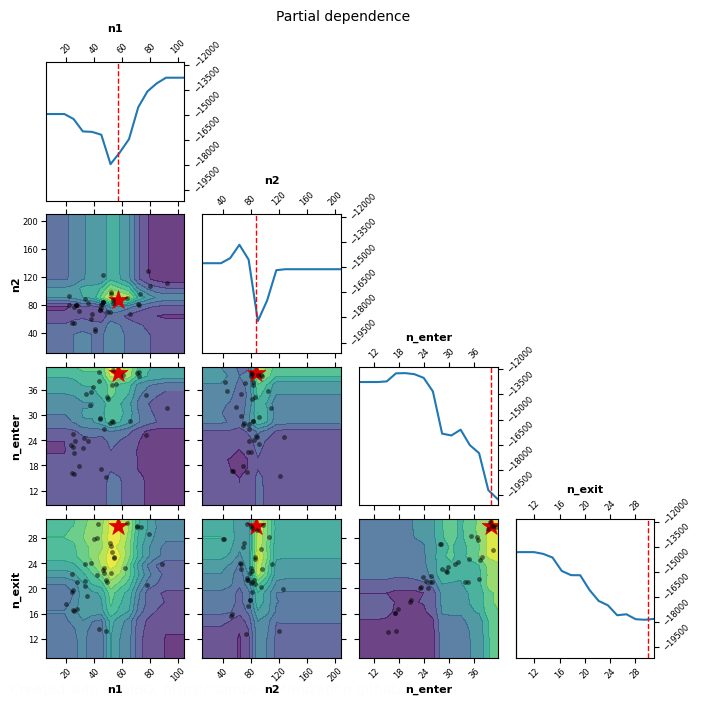

In [12]:
from sambo.plot import plot_objective

names = ['n1', 'n2', 'n_enter', 'n_exit']
_ = plot_objective(optimize_result, names=names, estimator='et')

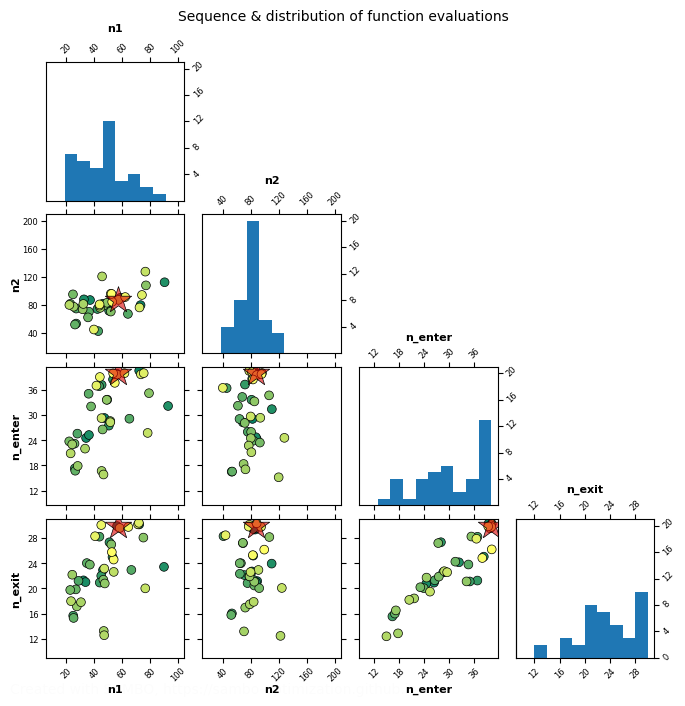

In [13]:
from sambo.plot import plot_evaluations

_ = plot_evaluations(optimize_result, names=names)

Learn more by exploring further
[examples](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#tutorials)
or find more framework options in the
[full API reference](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#header-submodules).